In [1]:
import pandas as pd
import seaborn as sns
from functools import reduce
from datetime import timedelta
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from time import time
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import SpectralClustering, MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from pandas.plotting import parallel_coordinates
%pylab inline

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Populating the interactive namespace from numpy and matplotlib


D:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Read datasets
olist_customers_dataset = pd.read_csv("D:\\IML\\projet4\\Data\\olist_customers_dataset.csv")
olist_order_items_dataset = pd.read_csv("D:\\IML\\projet4\\Data\\olist_order_items_dataset.csv")
olist_order_payments_dataset = pd.read_csv("D:\\IML\\projet4\\Data\\olist_order_payments_dataset.csv")
olist_order_reviews_dataset = pd.read_csv("D:\\IML\\projet4\\Data\\olist_order_reviews_dataset.csv")
olist_orders_dataset = pd.read_csv("D:\\IML\\projet4\\Data\\olist_orders_dataset.csv")
olist_products_dataset = pd.read_csv("D:\\IML\\projet4\\Data\\olist_products_dataset.csv")
olist_sellers_dataset = pd.read_csv("D:\\IML\\projet4\\Data\\olist_sellers_dataset.csv")

In [3]:
## Suppression des commandes qui ne figurent pas dans la base de données commande produits
order_id1 = olist_orders_dataset.order_id.unique().tolist()
order_id2 = olist_order_items_dataset.order_id.unique().tolist()
order_id3 = olist_order_reviews_dataset.order_id.unique().tolist()
order_id4 = olist_order_payments_dataset.order_id.unique().tolist()
GoodOrderItems = [elem for elem in order_id1 if elem in order_id2 and elem in order_id3 and elem in order_id4]
Good_customer_id = olist_orders_dataset[olist_orders_dataset.order_id.isin(GoodOrderItems)]['customer_id'].tolist()
olist_customers_dataset = olist_customers_dataset[olist_customers_dataset.customer_id.isin(Good_customer_id)]
olist_orders_dataset = olist_orders_dataset[olist_orders_dataset.order_id.isin(GoodOrderItems)]
olist_order_payments_dataset = olist_order_payments_dataset[olist_order_payments_dataset.order_id.isin(GoodOrderItems)]
olist_order_reviews_dataset = olist_order_reviews_dataset[olist_order_reviews_dataset.order_id.isin(GoodOrderItems)]
olist_order_items_dataset = olist_order_items_dataset[olist_order_items_dataset.order_id.isin(GoodOrderItems)]

In [4]:
 # Fusionnons les tables de données en utilisant les clés primaires et clés étrangères des tables
data_frames = [olist_order_items_dataset, olist_order_payments_dataset, olist_order_reviews_dataset, olist_orders_dataset]
df_merged1 = reduce(lambda left,right: pd.merge(left, right, on=['order_id'], how='outer'), data_frames)
df_merged2 = pd.merge(df_merged1, olist_customers_dataset, on = ['customer_id'], how = 'outer')
df_merged3 = pd.merge(df_merged2, olist_products_dataset, on = ['product_id'], how = 'outer')
df_final = pd.merge(df_merged3, olist_sellers_dataset, on = ['seller_id'], how = 'outer')

In [5]:
#Traitement de la base de données reviews dataset
df_final.loc[~df_final['review_comment_title'].isnull(), 'review_comment_title'] = 1
df_final.loc[df_final['review_comment_title'].isnull(), 'review_comment_title'] = 0
df_final.loc[~df_final['review_comment_message'].isnull(), 'review_comment_message'] = 1
df_final.loc[df_final['review_comment_message'].isnull(), 'review_comment_message'] = 0
    
#Traitement de la base de données products dataset
df_final.loc[:,'volume'] = df_final.loc[:,'product_length_cm']*df_final.loc[:,'product_height_cm']*df_final.loc[:,'product_width_cm']

# Convert date objects that are stored in string to Datetime
datetime = ['shipping_limit_date', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
            'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_creation_date', 'review_answer_timestamp']
for dt in datetime:
    df_final.loc[:,dt] = pd.to_datetime(df_final[dt], format='%Y-%m-%d %H:%M:%S')

#Creating news variables based on date objects
## Approval delay in seconde 
df_final.loc[:,'ApprovalDelay'] = (df_final.order_approved_at - df_final.order_purchase_timestamp)/timedelta(seconds=1)
## Delivery delay in seconde 
df_final.loc[:,'DeliveryDelay'] = (df_final.order_estimated_delivery_date - df_final.order_delivered_customer_date)/timedelta(seconds=1)
## Shipping delay in seconde 
df_final.loc[:,'ShippingDelay'] = (df_final.shipping_limit_date - df_final.order_delivered_carrier_date)/timedelta(seconds=1)
## Awaiting dispatch in seconde 
df_final.loc[:,'AwaitingDispatch'] = (df_final.shipping_limit_date - df_final.order_purchase_timestamp)/timedelta(seconds=1)
## Delivery delay in seconde 
df_final.loc[:,'DeliveryDelay'] = (df_final.order_delivered_customer_date - df_final.order_purchase_timestamp)/timedelta(seconds=1)
## Delivery delay estimated in seconde 
df_final.loc[:,'DeliveryDelayEst'] = (df_final.order_estimated_delivery_date - df_final.order_approved_at)/timedelta(seconds=1)
## Reviews delay in seconde 
df_final.loc[:,'ReviewDelay'] = (df_final.review_creation_date - df_final.order_purchase_timestamp)/timedelta(seconds=1)
## Reviews answer delay in seconde 
df_final.loc[:,'ReviewAnswerDelay'] = (df_final.review_answer_timestamp - df_final.review_creation_date)/timedelta(seconds=1)


In [6]:
df_final.shape

(118315, 47)

In [7]:
CustomerDataset = df_final.groupby('customer_unique_id').agg({'customer_unique_id': "count", 
                                                                'price': "sum",
                                                                'freight_value': "sum",
                                                                'payment_value': "sum",
                                                                'payment_sequential': "count",
                                                                'payment_installments': 'mean',
                                                                'review_comment_title': "sum",
                                                                'review_comment_message': "sum",
                                                                'review_score': "mean",
                                                                'product_weight_g': "mean",
                                                                'product_photos_qty': "mean",
                                                                'product_name_lenght': "mean",
                                                                'volume': "mean",
                                                                'ApprovalDelay': "mean",
                                                                'DeliveryDelay': "mean",
                                                                'ShippingDelay': "mean",
                                                                'AwaitingDispatch': "mean",
                                                                'DeliveryDelay': "mean",
                                                                'DeliveryDelayEst': "mean",
                                                                'ReviewDelay': "mean",
                                                                'ReviewAnswerDelay': "mean" 
                                                               })

In [8]:
#Le mode de payement le plus utilisé par le client
MostPT = df_final.groupby('customer_unique_id')['payment_type'].agg(pd.Series.mode).to_frame()
MostPT["payment_type"]= MostPT["payment_type"].str.join("_")

#Le status de la commande le plus couramment rencontré par le client
MostOS = df_final.groupby('customer_unique_id')['order_status'].agg(pd.Series.mode).to_frame()
MostOS["order_status"] = MostOS["order_status"].str.join("_")

#Fusion des bases de données
data_frames = [CustomerDataset, MostPT, MostOS]
CustomerFinal = reduce(lambda  left,right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), data_frames)

In [9]:
CustomerFinal.head()

,customer_unique_id,price,freight_value,payment_value,payment_sequential,payment_installments,review_comment_title,review_comment_message,review_score,product_weight_g,...,volume,ApprovalDelay,DeliveryDelay,ShippingDelay,AwaitingDispatch,DeliveryDelayEst,ReviewDelay,ReviewAnswerDelay,payment_type,order_status
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,12.00,141.90,1,8.0,1,1,5.0,1500.0,...,7616.0,891.0,553930.0,269598.0,432891.0,910122.0,565413.0,395088.0,c_r_e_d_i_t___c_a_r_d,d_e_l_i_v_e_r_e_d
0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,8.29,27.19,1,1.0,0,0,4.0,375.0,...,5148.0,26057.0,283875.0,193113.0,369906.0,624856.0,305313.0,80965.0,c_r_e_d_i_t___c_a_r_d,d_e_l_i_v_e_r_e_d
0000f46a3911fa3c0805444483337064,1,69.00,17.22,86.22,1,8.0,0,0,3.0,1500.0,...,43750.0,0.0,2223224.0,201993.0,432000.0,2343297.0,2256897.0,91184.0,c_r_e_d_i_t___c_a_r_d,d_e_l_i_v_e_r_e_d
0000f6ccb0745a6a4b88665a16c9f078,1,25.99,17.63,43.62,1,4.0,0,1,4.0,150.0,...,1045.0,1176.0,1731204.0,438058.0,523176.0,2689843.0,1740619.0,87471.0,c_r_e_d_i_t___c_a_r_d,d_e_l_i_v_e_r_e_d
0004aac84e0df4da2b147fca70cf8255,1,180.00,16.89,196.89,1,6.0,0,0,5.0,6050.0,...,528.0,1270.0,1135394.0,519282.0,692470.0,1741988.0,1138458.0,426575.0,c_r_e_d_i_t___c_a_r_d,d_e_l_i_v_e_r_e_d


In [10]:
CustomerFinal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95419 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_unique_id      95419 non-null  int64  
 1   price                   95419 non-null  float64
 2   freight_value           95419 non-null  float64
 3   payment_value           95419 non-null  float64
 4   payment_sequential      95419 non-null  int64  
 5   payment_installments    95419 non-null  float64
 6   review_comment_title    95419 non-null  int64  
 7   review_comment_message  95419 non-null  int64  
 8   review_score            95419 non-null  float64
 9   product_weight_g        95406 non-null  float64
 10  product_photos_qty      94107 non-null  float64
 11  product_name_lenght     94107 non-null  float64
 12  volume                  95406 non-null  float64
 13  ApprovalDelay           95406 non-null

In [11]:
CustomerFinal.isnull().any()

customer_unique_id        False
price                     False
freight_value             False
payment_value             False
payment_sequential        False
payment_installments      False
review_comment_title      False
review_comment_message    False
review_score              False
product_weight_g           True
product_photos_qty         True
product_name_lenght        True
volume                     True
ApprovalDelay              True
DeliveryDelay              True
ShippingDelay              True
AwaitingDispatch          False
DeliveryDelayEst           True
ReviewDelay               False
ReviewAnswerDelay         False
payment_type              False
order_status              False
dtype: bool

In [12]:
# Date de debut des achats du client
PurchaseTime = df_final.groupby('customer_unique_id').agg({'order_purchase_timestamp': "min"})
PurchaseTime.head()

,order_purchase_timestamp
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42


## Imputer les données manquantes

In [13]:
# Imputer les données manquantes
def MissingDataImp(data):
    float_features = make_column_selector(dtype_include = 'float64')
    int_features = make_column_selector(dtype_include = 'int64')
    categorical_features = make_column_selector(dtype_include = 'object')
    dt1 = data[float_features]
    dt2 = data[int_features]
    dt3 = data[categorical_features]
    
    Float_pipeline = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'))
    Int_pipeline = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'))
    Categorical_pipeline = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    dt11 = Float_pipeline.fit_transform(dt1)
    dt11 = pd.DataFrame(dt11, index = dt1.index, columns = dt1.columns)
    dt21 = Int_pipeline.fit_transform(dt2)
    dt21 = pd.DataFrame(dt21, index = dt2.index, columns = dt2.columns)
    dt31 = Categorical_pipeline.fit_transform(dt3)
    dt31 = pd.DataFrame(dt31, index = dt3.index, columns = dt3.columns)
    data_frames = [dt11, dt21, dt31]
    data = reduce(lambda  left,right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), data_frames)
    return data

In [14]:
CustomerFinal = MissingDataImp(CustomerFinal)

In [15]:
CustomerFinal.isnull().any()

price                     False
freight_value             False
payment_value             False
payment_installments      False
review_score              False
product_weight_g          False
product_photos_qty        False
product_name_lenght       False
volume                    False
ApprovalDelay             False
DeliveryDelay             False
ShippingDelay             False
AwaitingDispatch          False
DeliveryDelayEst          False
ReviewDelay               False
ReviewAnswerDelay         False
customer_unique_id        False
payment_sequential        False
review_comment_title      False
review_comment_message    False
payment_type              False
order_status              False
dtype: bool

In [16]:
CustomerFinal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95419 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   95419 non-null  float64
 1   freight_value           95419 non-null  float64
 2   payment_value           95419 non-null  float64
 3   payment_installments    95419 non-null  float64
 4   review_score            95419 non-null  float64
 5   product_weight_g        95419 non-null  float64
 6   product_photos_qty      95419 non-null  float64
 7   product_name_lenght     95419 non-null  float64
 8   volume                  95419 non-null  float64
 9   ApprovalDelay           95419 non-null  float64
 10  DeliveryDelay           95419 non-null  float64
 11  ShippingDelay           95419 non-null  float64
 12  AwaitingDispatch        95419 non-null  float64
 13  DeliveryDelayEst        95419 non-null

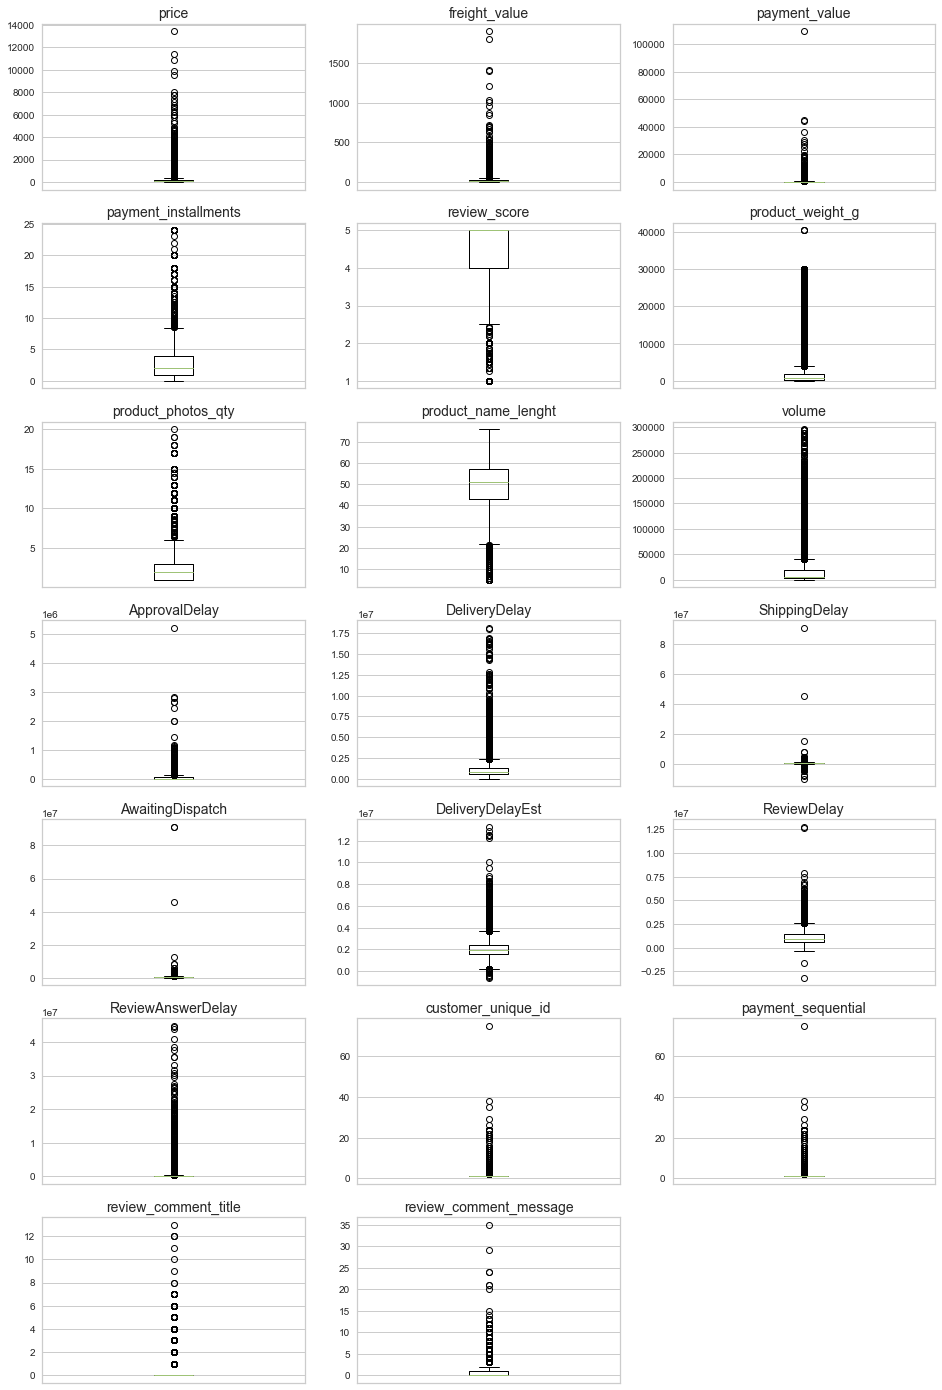

In [17]:
NumericColumnsSelector = make_column_selector(dtype_include = 'float64')
numerical_features = CustomerFinal[NumericColumnsSelector].columns.tolist()
# Analyse des outliers
m = len(numerical_features)
if m % 3 == 0:
    n = int(len(numerical_features)/3)
else:
    n = int(len(numerical_features)/3)+1
fig = plt.figure(figsize = (16,25))
for k in range(len(numerical_features)):
    ax = fig.add_subplot(n, 3, (k+1))
    h = ax.boxplot(CustomerFinal.loc[:,numerical_features[k]])
    ax.set_title(numerical_features[k], fontsize = 14)
    ax.set_xticks([])
    ax.set_xticklabels('')

## Reduction de dimension

Pour notre réduction de dimension, nous aurons recourt à la méthode FAMD (Factor analysis for mixed data). Cette méthode a l'avantage de prendre en compte les varaibles numériques et non numériques afin de construire les axes principaux.  

In [18]:
def preproFAMD(data):
    
    '''Cette fonction prend la base de données et standardise les variables numériques 
         tout en concervant les vriables catégorielles intacts dans la base'''
    
    numerical_features = make_column_selector(dtype_include = np.number)
    categorical_features = make_column_selector(dtype_exclude = np.number)
    dt1 = data[numerical_features]
    dt2 = data[categorical_features]
    numerical_pipeline = make_pipeline(StandardScaler())
    dt11 = numerical_pipeline.fit_transform(dt1)
    dt11 = pd.DataFrame(dt11, index = dt1.index, columns = dt1.columns)
    data_frames = [dt11, dt2]
    data = reduce(lambda  left,right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), data_frames)
    return data

In [19]:
#Transformation de la base de données CustomerFinal pour la FAMD
OlistdataTransform = preproFAMD(CustomerFinal)
OlistdataTransform.shape

In [21]:
# FAMD is in prince library so we are import that library.
import prince
famd = prince.FAMD(n_components=22, n_iter=10, copy=True, check_input=True, engine='auto', random_state=42)
famd.fit(OlistdataTransform)

FAMD(n_components=22, n_iter=10, random_state=42)

In [22]:
def display_scree_plot_FAMD(famd):
    '''Le scree plot de la FAMD'''

    scree = [elem *100 for elem in famd.explained_inertia_]
    scree_cumsum = np.cumsum(scree).tolist()
    plt.figure(figsize = (20,8))
    plt.plot(np.arange(len(scree))+1, scree, c="blue",marker='x')
    plt.plot(np.arange(len(scree))+1, scree_cumsum,c="red",marker='o')
    plt.axvline(x = 2, color = 'gray', linestyle ='--')
    plt.xlabel("Nombre de composantes principales")
    plt.ylabel("Pourcentage de la variance expliquée")
    plt.title("Scree plot")
    plt.show(block=False)

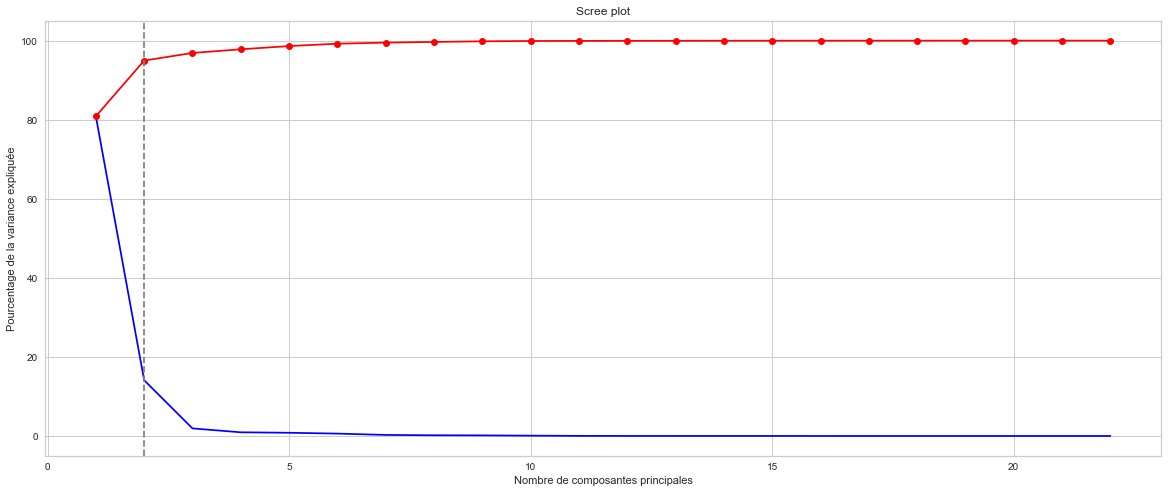

In [23]:
display_scree_plot_FAMD(famd) 

In [24]:
np.cumsum(famd.explained_inertia_)[:1]

array([0.80857864])

Les deux premiers axes principaux capturent plus de 80% de la variabilité totale du nuage de points. Nous baserons notre étude sur les deux premiers axes principaux.

In [25]:
famd2 = prince.FAMD(n_components=2, n_iter=10, copy=True, check_input=True, engine='auto', random_state=42)
OlistdataFAMDrep = famd2.fit_transform(OlistdataTransform)

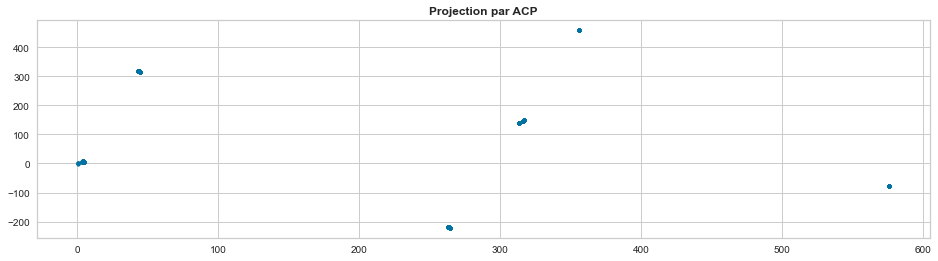

In [26]:
plt.figure(figsize=(16, 4))
plt.scatter(OlistdataFAMDrep.loc[:, 0], OlistdataFAMDrep.loc[:, 1], alpha=0.6, marker='.')
plt.title('Projection par ACP', fontsize=12, weight='bold')
plt.show()

Nous constatons un regroupement en 6 classes sur le graphique.

In [27]:
OlistdataFAMDrep.head()

,0,1
customer_unique_id,,
0000366f3b9a7992bf8c76cfdf3221e2,576.204479,-78.934479
0000b849f77a49e4a4ce2b2a4ca5be3f,576.204374,-78.933054
0000f46a3911fa3c0805444483337064,576.204429,-78.934474
0000f6ccb0745a6a4b88665a16c9f078,576.204380,-78.933689
0004aac84e0df4da2b147fca70cf8255,576.204442,-78.934063


Afin d'accélerer les calculs, nous allons travailler sur un échantillon de 15 000 clients

In [28]:
PurchaseTime = PurchaseTime.sample(15000, random_state=21)
OlistdataFAMDSample = OlistdataFAMDrep.loc[PurchaseTime.index,:]

In [29]:
OlistdataFAMD_scale = StandardScaler().fit_transform(OlistdataFAMDSample)

## Modélisation

In [30]:
#Tuning n_clusters for each models (elbows plot)

In [31]:
#kmean = KMeans(init='k-means++', n_clusters= , n_init=10)

In [32]:
n_iter = 5

silhouettes = np.zeros([n_iter, 6])

for i in range(n_iter):
    for n_cluster in range(4, 10):
        cls = KMeans(n_clusters=n_cluster, n_init=10, random_state=1)
        cls.fit(OlistdataFAMD_scale)
        silhouettes[i, n_cluster-4] = silhouette_score(OlistdataFAMD_scale, cls.labels_)
sil = silhouettes.mean(axis=0).tolist()
n_clusterKMean = sil.index(max(sil)) + 4

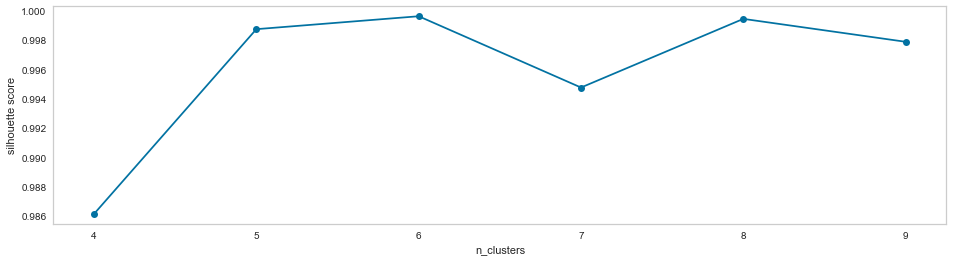

In [33]:
#Plot
plt.figure(figsize=(16, 4))
plt.plot(range(4, 10), silhouettes.mean(axis=0), marker='o')
plt.xlabel('n_clusters')
plt.ylabel('silhouette score')
plt.grid()

L'algorithme du KMean donne un meilleur score de silhouette en 6 classes.

In [34]:
#minibatchkmeans = MiniBatchKMeans(n_clusters =  )

In [35]:
silhouettes = []

for n_cluster in range(4, 10):
    cls = MiniBatchKMeans(n_clusters=n_cluster, random_state=1)
    cls.fit(OlistdataFAMD_scale)
    silhouettes.append(silhouette_score(OlistdataFAMD_scale, cls.labels_))
    
n_clusterMBKMean = silhouettes.index(max(silhouettes)) + 4

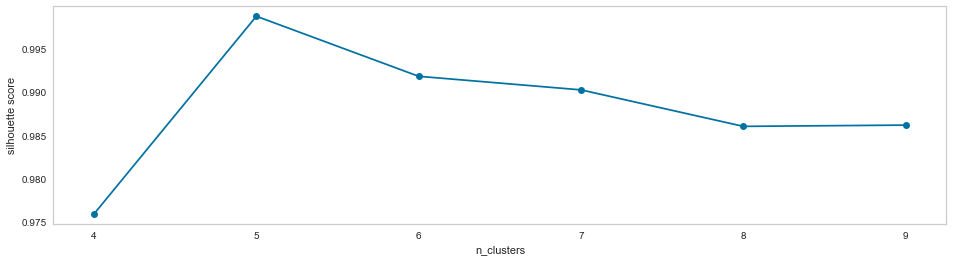

In [36]:
#Plot
plt.figure(figsize=(16, 4))
plt.plot(range(4, 10), silhouettes, marker='o')
plt.xlabel('n_clusters')
plt.ylabel('silhouette score')
plt.grid()

L'algorithme du MiniBatchKMeans donne un meilleur score de silhouette en 5 classes.

In [37]:
#agglomerative = AgglomerativeClustering(n_clusters =  )

In [38]:
silhouettes = []

for n_cluster in range(4, 10):
    cls = AgglomerativeClustering(n_clusters=n_cluster)
    cls.fit(OlistdataFAMD_scale)
    silhouettes.append(silhouette_score(OlistdataFAMD_scale, cls.labels_))
    
n_clusterAC = silhouettes.index(max(silhouettes)) + 4

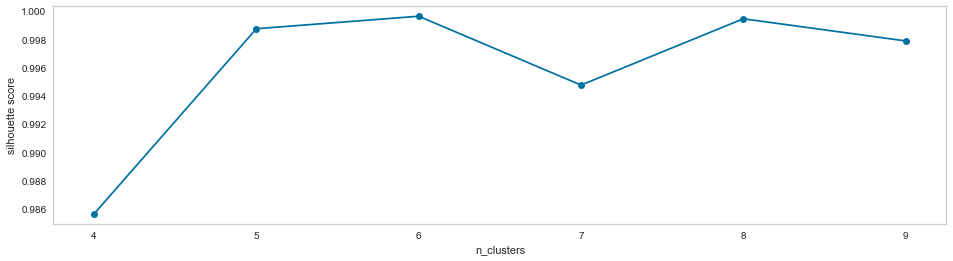

In [39]:
#Plot
plt.figure(figsize=(16, 4))
plt.plot(range(4, 10), silhouettes, marker='o')
plt.xlabel('n_clusters')
plt.ylabel('silhouette score')
plt.grid()

L'algorithme du AgglomerativeClustering donne un meilleur score de silhouette en 6 classes.

In [40]:
#spectral = SpectralClustering(n_clusters =  )

In [41]:
silhouettes = []

for n_cluster in range(4, 8):
    cls = SpectralClustering(n_clusters=n_cluster, random_state=1)
    cls.fit(OlistdataFAMD_scale)
    silhouettes.append(silhouette_score(OlistdataFAMD_scale, cls.labels_))

n_clusterSC = silhouettes.index(max(silhouettes)) + 4

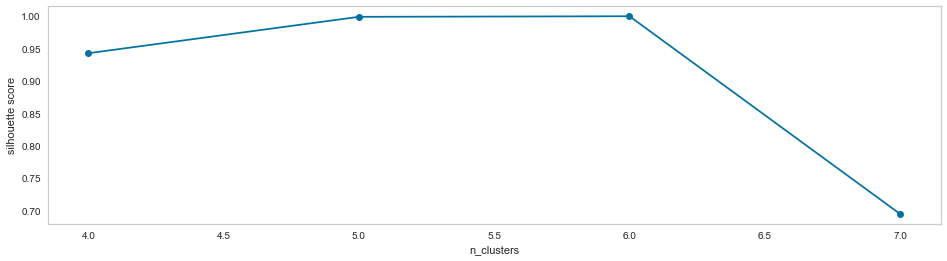

In [42]:
##Plot
plt.figure(figsize=(16, 4))
plt.plot(range(4, 8), silhouettes, marker='o')
plt.xlabel('n_clusters')
plt.ylabel('silhouette score')
plt.grid()

L'algorithme du SpectralClustering donne un meilleur score de silhouette en 6 classes.

In [43]:
# Density-based Clustering (DBSCAN)

In [44]:
N_clusters = []
Sil_score = []
Distance = np.linspace(10**(-4), 3, 10**(2))
for dist in Distance:
    db = DBSCAN(eps=dist, min_samples=100, algorithm='kd_tree', n_jobs=-1)
    db.fit(OlistdataFAMD_scale)
    n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    N_clusters.append(n_clusters_)
    Sil_score.append((silhouette_score(OlistdataFAMD_scale, db.labels_)
                      if n_clusters_ > 1 else 0))
n_clusterAC = N_clusters[Sil_score.index(max(Sil_score))]
DBSCANdist = Distance[Sil_score.index(max(Sil_score))]

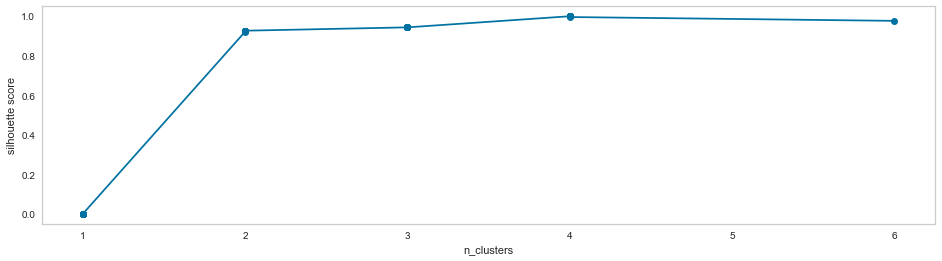

In [45]:
##Plot
plt.figure(figsize=(16, 4))
plt.plot(N_clusters, Sil_score, marker='o')
plt.xlabel('n_clusters')
plt.ylabel('silhouette score')
plt.grid()

L'algorithme du DBSCAN donne un meilleur score de silhouette en 4 classes.

## Comaparaison des modèles

In [46]:
from time import time
def CompareModelPerformance(models, dataset):
    columns_names = [model.__class__.__name__ for model in models]
    ModelsPerf = pd.DataFrame(data = np.zeros((4,len(models))), 
                              index=['time', 'CHS', 'DBS', 'silhouette'], 
                              columns=columns_names)
    for counter, mod in enumerate(models):
        t0 = time()
        mod.fit(dataset)
        actualtime = time() - t0
        CHsc = metrics.calinski_harabasz_score(dataset, mod.labels_)
        DBsc = metrics.davies_bouldin_score(dataset, mod.labels_)
        Silsc = metrics.silhouette_score(dataset, mod.labels_)
        ModelsPerf[columns_names[counter]].iloc[0] = actualtime
        ModelsPerf[columns_names[counter]].iloc[1] = CHsc
        ModelsPerf[columns_names[counter]].iloc[2] =  DBsc
        ModelsPerf[columns_names[counter]].iloc[3] =  Silsc
    return ModelsPerf

In [47]:
kmean = KMeans(n_clusters= n_clusterKMean , n_init=10, random_state=1)
minibatchkmeans = MiniBatchKMeans(n_clusters = n_clusterMBKMean , random_state=1)
agglomerative = AgglomerativeClustering(n_clusters = n_clusterAC)
spectral = SpectralClustering(n_clusters = n_clusterSC , random_state=1)
dbscan = DBSCAN(eps=DBSCANdist, min_samples=100, algorithm='kd_tree', n_jobs=-1)

models = [kmean, minibatchkmeans, agglomerative, spectral, dbscan]

In [48]:
CompareModelPerformance(models, OlistdataFAMD_scale)

,KMeans,MiniBatchKMeans,AgglomerativeClustering,SpectralClustering,DBSCAN
time,4.697328e-01,1.665528e-01,24.653346,1.372582e+02,7.509925e+00
CHS,9.358639e+08,4.334547e+06,270894.565942,9.358639e+08,4.334547e+06
DBS,8.150898e-03,1.343380e-01,0.253144,8.150898e-03,1.343380e-01
silhouette,9.996252e-01,9.987429e-01,0.985648,9.996252e-01,9.987429e-01


D'après le tableau ci-dessus, nous pouvons retenir l'algorithme du KMeans comme etant le meilleur modèle en terme de time d'exécution et de score de la silhouette.

In [49]:
bestmodel = kmean

## Analyse du meilleur model

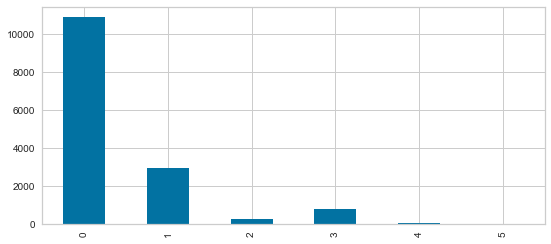

In [51]:
# Répartition des clients dans les clusters
pd.Series(bestmodel.labels_).value_counts().sort_index().plot.bar(figsize=(9, 4))

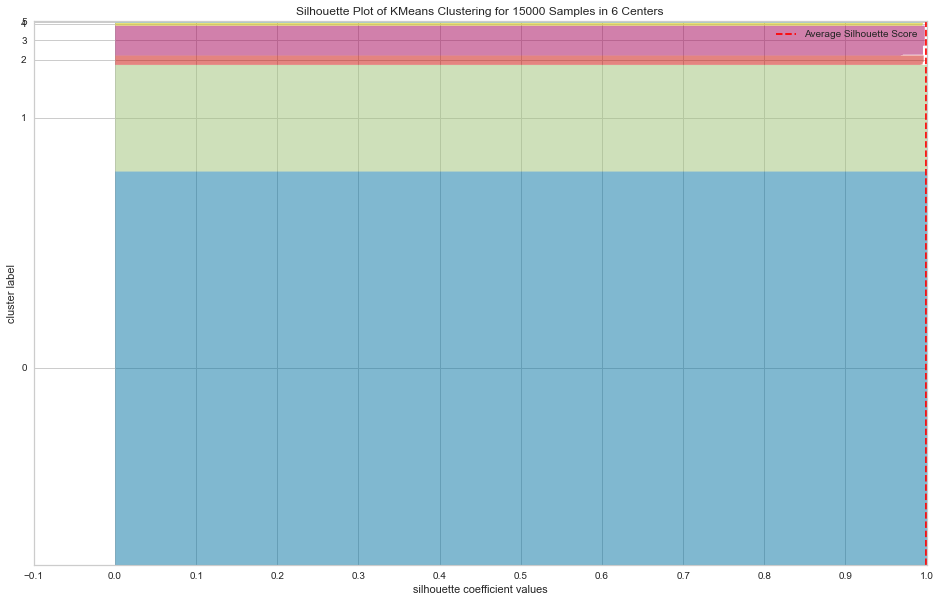

In [52]:
#Etude des silhouettes des clusters
fig = plt.figure(figsize=(16, 10))

visualizer = SilhouetteVisualizer(bestmodel, colors='yellowbrick')
visualizer.fit(OlistdataFAMD_scale)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Determination des variables importantes

In [53]:
class DummyTransformer(TransformerMixin):

    def __init__(self):
        self.dv = None

    def fit(self, X, y=None):
        # assumes all columns of X are strings
        Xdict = X.to_dict('records')
        self.dv = DictVectorizer(sparse=False)
        self.dv.fit(Xdict)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xdict = X.to_dict('records')
        Xt = self.dv.transform(Xdict)
        cols = self.dv.get_feature_names()
        Xdum = pd.DataFrame(Xt, index=X.index, columns=cols)
        # drop column indicating NaNs
        nan_cols = [c for c in cols if '=' not in c]
        Xdum = Xdum.drop(nan_cols, axis=1)
        return Xdum

In [54]:
def dataPrepro(data):
    numerical_features = make_column_selector(dtype_include = np.number)
    categorical_features = make_column_selector(dtype_exclude = np.number)
    dt1 = data[numerical_features]
    dt2 = data[categorical_features]
    numerical_pipeline = make_pipeline(StandardScaler())
    categorical_pipeline = make_pipeline(DummyTransformer())
    dt11 = numerical_pipeline.fit_transform(dt1)
    dt11 = pd.DataFrame(dt11, index = dt1.index, columns = dt1.columns)
    dt21 = categorical_pipeline.fit_transform(X=dt2)
    data_frames = [dt11, dt21]
    data = reduce(lambda  left,right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), data_frames)
    return data

In [55]:
OlistdataLabel = pd.DataFrame(bestmodel.predict(OlistdataFAMD_scale), index=PurchaseTime.index.tolist(), columns=['Class'])
OlistdataSample = OlistdataTransform.loc[PurchaseTime.index,:]
#Olistdatafinal = pd.merge(OlistdataSample, OlistdataLabel, left_index=True, right_index=True, how='outer')
OlistdataSample2 = dataPrepro(OlistdataSample)
OlistdataSamplefinal = pd.merge(OlistdataSample2, OlistdataLabel, left_index=True, right_index=True, how='outer')

In [56]:
OlistdataSamplefinal.shape

(15000, 39)

Ayant obtenu les clusters, nous utiliserons un modèle supervisé pour determiner l'importance des variables sur les classes obtenues. Le modèle retnu dans la suite est le random forest classifier.

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
#determiner les variables qui expliquent au mieux cette clustering
#important features

def selected_features_rf(data, target, threshold):
    rf = RandomForestClassifier()
    rf.fit(data, target.values.flatten())
    # Store the top most important features based off rf regressor
    rf_feature_importance_df = pd.DataFrame(rf.feature_importances_, index=data.columns, columns=['Importance_Value'])
    rf_feature_importance_df = rf_feature_importance_df[rf_feature_importance_df.Importance_Value >= threshold]
    rf_top_features = rf_feature_importance_df.sort_values(by = ['Importance_Value'], ascending=False)
    plt.figure(figsize = (12,8))
    ax = sns.barplot(x = rf_top_features.index, y = 'Importance_Value', data=rf_top_features)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize = 12, rotation=40, ha="right")
    plt.title('Top Features - Random Forest Regression')
    plt.show()
    selectedFeaturesRF = rf_top_features[rf_top_features.Importance_Value >= threshold].index.tolist()
    return selectedFeaturesRF

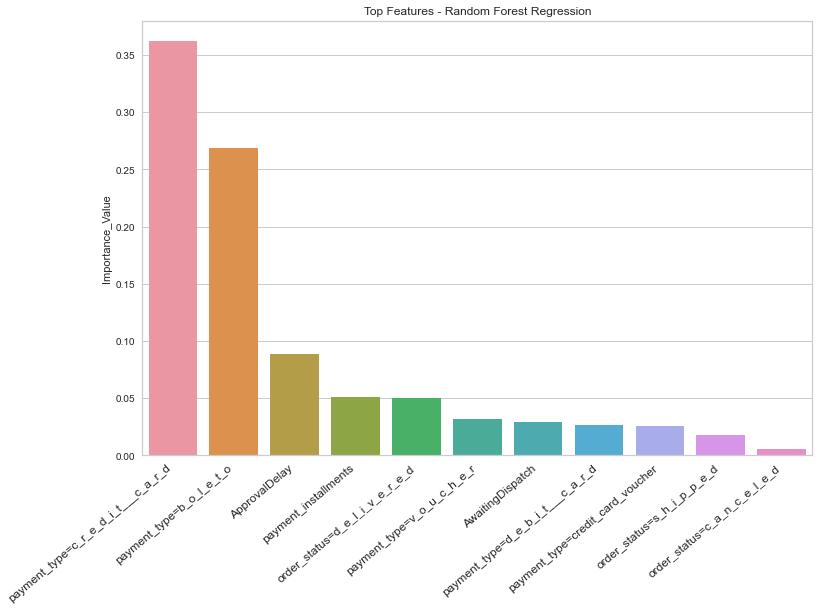

In [59]:
target = OlistdataLabel['Class']
selectedFeaturesRF = selected_features_rf(OlistdataSample2, target, 0.005)

In [60]:
selectedFeaturesRF

['payment_type=c_r_e_d_i_t___c_a_r_d',
 'payment_type=b_o_l_e_t_o',
 'ApprovalDelay',
 'payment_installments',
 'order_status=d_e_l_i_v_e_r_e_d',
 'payment_type=v_o_u_c_h_e_r',
 'AwaitingDispatch',
 'payment_type=d_e_b_i_t___c_a_r_d',
 'payment_type=credit_card_voucher',
 'order_status=s_h_i_p_p_e_d',
 'order_status=c_a_n_c_e_l_e_d']

Nous pouvons constater que le type de payement est très déterminant pour la constitution des classes. 

In [61]:
def features_filter(df, low_exclusive = 2, high_inclusive = 10):
    """function returns features (col_names) that have unique values
    less than or equal to n_categories
    
    """ 
    list_of_features = []
    for i in df.columns:
        if low_exclusive == high_inclusive:
            if df[i].nunique() <= low_exclusive :
                list_of_features.append(i)
        else:
            if df[i].nunique() <= high_inclusive and df[i].nunique() > low_exclusive :
                list_of_features.append(i)
    return list_of_features

In [62]:
#Parallele ploting

palette = sns.color_palette("bright", 10)

def addAlpha(colour, alpha):
    '''Add an alpha to the RGB colour'''
    
    return (colour[0],colour[1],colour[2],alpha)

def display_parallel_coordinates(df, num_clusters):
    '''Display a parallel coordinates plot for the clusters in df'''

    # Select data points for individual clusters
    cluster_points = []
    for i in range(num_clusters):
        cluster_points.append(df[df.Class==i])
    
    # Create the plot
    fig = plt.figure(figsize=(12, 30))
    title = fig.suptitle("Parallel Coordinates Plot for the Clusters", fontsize=18)
    fig.subplots_adjust(top=0.95, wspace=0)

    # Display one plot for each cluster, with the lines for the main cluster appearing over the lines for the other clusters
    for i in range(num_clusters):    
        plt.subplot(num_clusters, 1, i+1)
        for j,c in enumerate(cluster_points): 
            if i!= j:
                pc = parallel_coordinates(c, 'Class', color=[addAlpha(palette[j],0.2)])
        pc = parallel_coordinates(cluster_points[i], 'Class', color=[addAlpha(palette[i],0.5)])

        # Stagger the axes
        ax=plt.gca()
        for tick in ax.xaxis.get_major_ticks()[1::2]:
            tick.set_pad(20) 

In [63]:
ImpFeat = selectedFeaturesRF.copy()
ImpFeat.append('Class')
dataSelect = OlistdataSamplefinal[ImpFeat]

BinaryFeatures = features_filter(dataSelect, 1, 2)

BinImpFeat = [element for element in BinaryFeatures if element in selectedFeaturesRF]
NumImpFeat = [element for element in selectedFeaturesRF if element not in BinImpFeat]

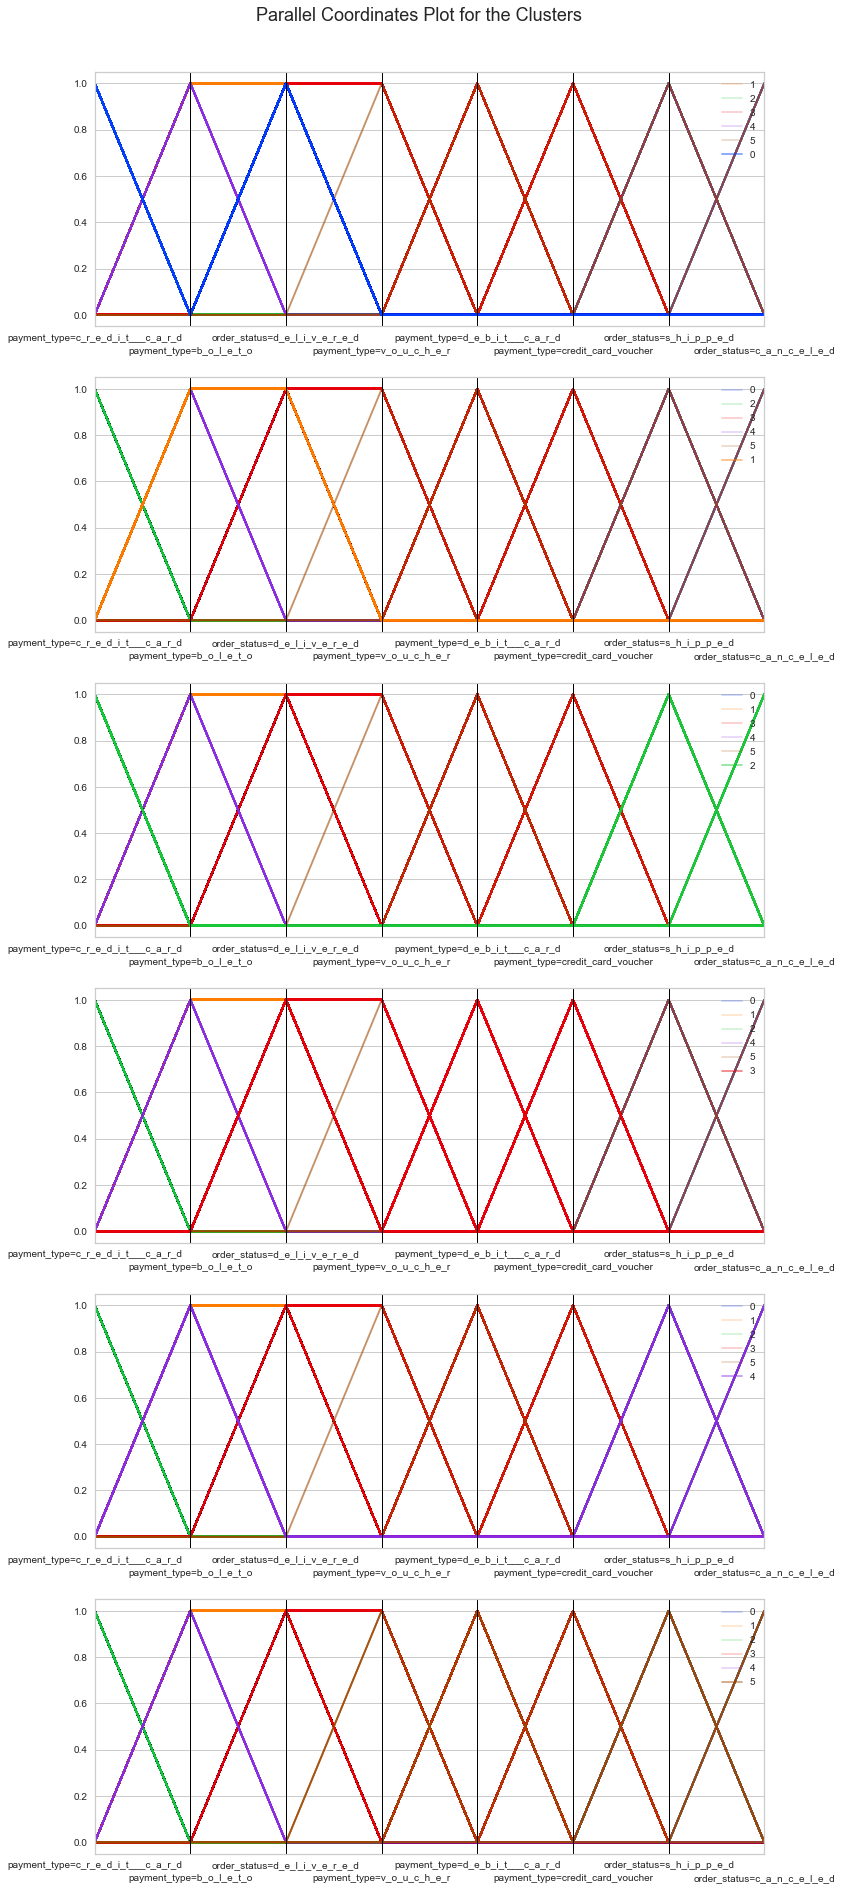

In [64]:
BinImpFeat.append('Class')
BinData = dataSelect[BinImpFeat]

# Display parallel coordinates plots, one for each cluster
display_parallel_coordinates(BinData, 6)

- Classe 0 : clients qui payent par carte de crédit et dont les commandes sont livrées
- Classe 1 : clients qui payent par boleto et dont les commandes sont livrées
- Classe 2 : clients qui payent par carte de crédit et dont les commandes sont à court d'achéminement ou annulées
- Classe 3 : clients qui ont un mode de payement varié et dont les commandes sont livrées
- Classe 4 : clients qui payent par boleto et dont les commandes sont sont à court d'achéminement ou annulées
- Classe 5 : clients qui ont un mode de payement varié et dont les commandes sont sont à court d'achéminement ou annulées

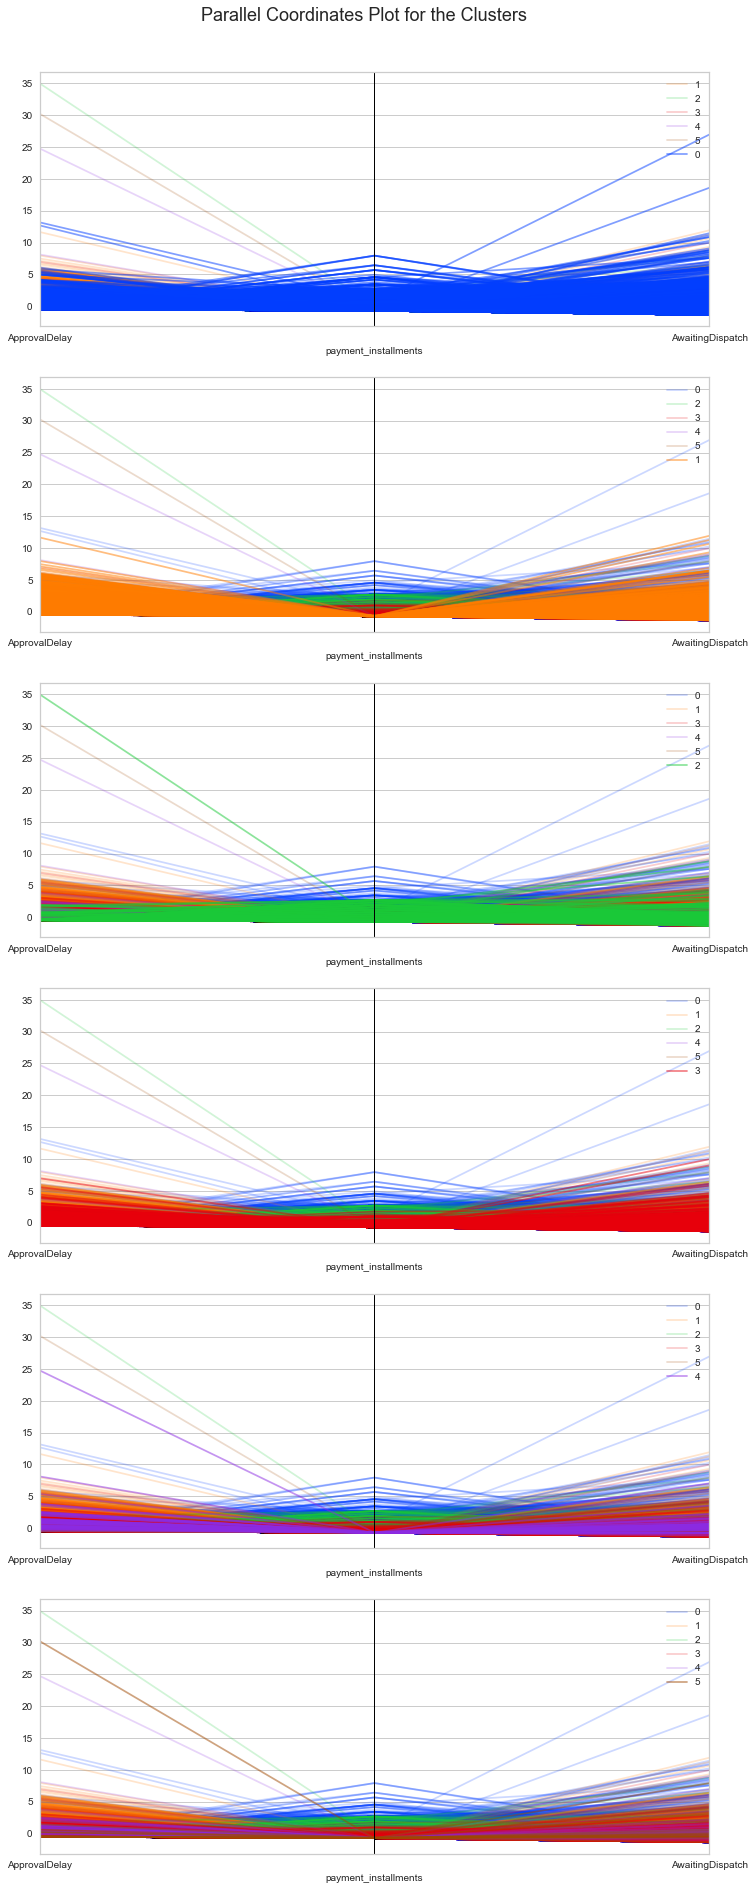

In [65]:
NumImpFeat.append('Class')
NumData = dataSelect[NumImpFeat]

# Display parallel coordinates plots, one for each cluster
display_parallel_coordinates(NumData, 6)

Le nombre de versements choisis par le client caractérise le plus les classes.

## Stabilité des clusters dans le temps

In [ ]:
OlistdataFAMD_scale

In [67]:
OlistdataFAMD_scale2 = pd.DataFrame(OlistdataFAMD_scale, index = PurchaseTime.index, columns = ['Factor1', 'Factor2'])
CompletOlistdataSample = pd.merge(PurchaseTime, OlistdataFAMD_scale2, left_index=True, right_index=True,  how = 'outer')
#CompletOlistdataSample = pd.merge(PurchaseTime, OlistdataSample2, left_index=True, right_index=True,  how = 'outer')

Text(0.5, 0, 'Months')

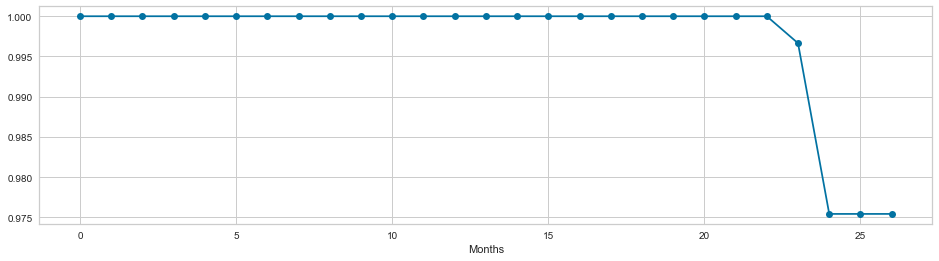

In [77]:
CompletOlistdataSample['year'] = CompletOlistdataSample.order_purchase_timestamp.dt.year
CompletOlistdataSample['month'] = CompletOlistdataSample.order_purchase_timestamp.dt.month
year =  unique(CompletOlistdataSample.year).tolist()
month =  unique(CompletOlistdataSample.month).tolist()
datasets = []
MetricScores = []
for y in year:
    for m in month:
        data = CompletOlistdataSample.loc[(CompletOlistdataSample.year == y) & (CompletOlistdataSample.month == m),:]
        datasets.append(data)
df_merge = []
for i in range(len(datasets)):
    df_merge.append(datasets[i])
    if len(df_merge) == 1 :
        OlistdataFinal = df_merge[0]
        if len(OlistdataFinal) >= n_clusterKMean:
            OlistdataFinal.drop(['order_purchase_timestamp', 'year', 'month'], axis = 1 , inplace = True)
            bestmodel.fit(OlistdataFinal)
            labels_true = OlistdataSamplefinal.loc[OlistdataFinal.index, 'Class'].tolist()
            MetricScores.append(adjusted_rand_score(labels_true, bestmodel.labels_))
    else:
        OlistdataFinal = pd.concat(df_merge)
        if len(OlistdataFinal) >= n_clusterKMean:
            OlistdataFinal.drop(['order_purchase_timestamp', 'year', 'month'], axis = 1 , inplace = True)
            bestmodel.fit(OlistdataFinal)
            labels_true = OlistdataSamplefinal.loc[OlistdataFinal.index, 'Class'].tolist()
            MetricScores.append(adjusted_rand_score(labels_true, bestmodel.labels_))

MetricScores.reverse()
#Plot
fig = plt.figure(figsize=(16, 4))
plt.plot(range(len(MetricScores)), MetricScores, marker='o')
plt.xlabel('Months')

### Conclusion : on peut considérer que les clusters sont stables sur une période de 22 mois